In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import itertools
import numpy   as     np
from   numba   import njit
from   os.path import join
from   src_dir import Gauss_pdf_2D, GMRES, GMRES_numba, mk_laplace_2d, laplace_2d_dirichlet, laplace_2d_extrap, laplace_2d_constextrap, resid

In [3]:
import torch
torch.cuda.is_available()

True

In [4]:
# Set dimension of the NxN grid used
# Note: For optimal performance, the neural network "cnn_collectionOnline2D.py"
# can be tweaked with appropriate kernel dilations, however the code should
# still work and yield resuluts for any dimension of input provided
dim = 80

# Default initial guess used for direct un-preconditioned GMRES is the zero
# solution
x0 = np.squeeze(np.zeros((dim,dim)))

# Set tolerances for GMRES solver
e = 1e-6

# Restarted GMRES parameters
nmax_iter = 10   # int(dim/5)
restart   = 10000

# Create domain [-1,1]x[-1,1]
# Define grid values at midpoints of cartesian grid
DomainL = -1.0
DomainR =  1.0
dx = (DomainR-DomainL)/(dim-1)
x1 = np.linspace(DomainL+dx,DomainR-dx,dim)
x2 = np.linspace(DomainL+dx,DomainR-dx,dim)
X, Y = np.meshgrid(x1, x2, sparse=False, indexing='ij')
Area = (dx*(dim-1))**2

# Create 2D laplace opertor as a stencil opertor for a N-cell 2D grid
# Can be found in linop.py in src_di
@njit(nogil=True)
def A_numba(x):
    return laplace_2d_extrap(x)
AType = '2D Laplacian'

# Uniform time-step used
dt = 1e-4
n_steps = 10000

In [5]:
def particle(X, Y, x, y, charge, sigma):
    b = charge*Gauss_pdf_2D(X, Y, x, y, sigma)
    b[0,  :] = 0
    b[-1, :] = 0
    b[:,  0] = 0
    b[:, -1] = 0
    return b

def force(dx, X, Y, phi_x, phi_y, x, y,sigma):
    weights = Gauss_pdf_2D(X, Y, x, y, sigma)
    return np.array([
        np.sum(phi_x*weights),
        np.sum(phi_y*weights)
    ])*dx**2

In [6]:
from src_dir import cnn_preconditionerOnline_timed_2D, CNNPredictorOnline_2D,\
                    timer, GMRES, PreconditionerTrainer, FluidNet2D30

# Note: # Model dimention inputs are not used for the current network in cnn_predictorOnline2D.py (but must be passed into wrapper)
InputDim  = dim
OutputDim = dim
# Number of samples to collect before using preduction from Neural Network:
Initial_set = 32

nn_precon = CNNPredictorOnline_2D(InputDim, OutputDim, Area, dx, FluidNet2D30)
# TODO: using diagnostic_probe=10 => end of first inner loop for the current setup => generalize this
trainer   = PreconditionerTrainer(nn_precon, Initial_set=Initial_set, diagnostic_probe=22)

@timer
@cnn_preconditionerOnline_timed_2D(trainer)
def MLGMRES(A, b, x0, e, nmax_iter, restart, debug):
    return GMRES_numba(A, b, x0, e, nmax_iter, restart, debug)

@timer
def GMRES_timed(A, b, x0, e, nmax_iter, restart, debug):
    return GMRES_numba(A, b, x0, e, nmax_iter, restart, debug)

In [7]:
def time_step(sol_fn, mot, dt, dx, X, Y, p_0, v_0, p_lo, p_hi, charge, sigma):
    b = particle(X, Y, *p_0[0, :], charge[0], sigma)
    for i in range(1, len(charge)):
        b += particle(X, Y, *p_0[i, :], charge[i], sigma)
    
    Out, run_time = sol_fn(A_numba, b, x0, e, nmax_iter, restart, True)
    phi = Out[-1]
    # this is pretty powerful: https://numpy.org/doc/stable/reference/generated/numpy.gradient.html
    phi_x, phi_y = np.gradient(phi)
    
    p_1 = np.zeros_like(p_0)
    v_1 = np.zeros_like(v_0)
    for i in range(1, len(charge)):
        v_1[i, :] = v_0[i, :] + mot*dt*charge[i]*force(dx, X, Y, phi_x, phi_y, *p_0[i,:], sigma)
        p_1[i, :] = p_0[i, :] + dt*v_1[i,:]
        if p_1[i, 0] < p_lo:
            p_1[i, 0] = p_lo
            v_1[i, 0] = - v_1[i, 0]
        if p_1[i, 0] > p_hi:
            p_1[i, 0] = p_hi
            v_1[i, 0] = - v_1[i, 0]
        if p_1[i, 1] < p_lo:
            p_1[i, 1] = p_lo
            v_1[i, 1] = - v_1[i, 1]
        if p_1[i, 1] > p_hi:
            p_1[i, 1] = p_hi
            v_1[i, 1] = - v_1[i, 1]
    
    return p_1, v_1, b, phi, phi_x, phi_y, Out, run_time

In [8]:
p_0 = np.array([[-0.32336585,  0.65426417],
       [ 0.99695835, -0.55919024],
       [ 0.57414741, -0.70997247],
       [ 0.17239934, -0.19735975],
       [ 0.21289987,  0.91777169],
       [ 0.2290385 ,  0.52141195],
       [-0.461091  , -0.24082868],
       [ 0.87416939, -0.97180547],
       [ 0.27237462, -0.74976046],
       [-0.50083594,  0.9033211 ],
       [ 0.95405276,  0.66377531],
       [-0.19232476, -0.38316569],
       [-0.5439799 , -0.60119878],
       [-0.80170428,  0.97916761],
       [-0.35557476,  0.18080847],
       [ 0.12343328,  0.72446035],
       [ 0.68443256, -0.34386402],
       [-0.54183484,  0.20051936],
       [-0.96628812,  0.7855199 ],
       [-0.11312355, -0.20353866],
       [-0.07084636,  0.80498987],
       [-0.87940228,  0.90851145],
       [-0.92274332,  0.52025615],
       [-0.33131686,  0.62735958],
       [ 0.40828374, -0.80497079],
       [-0.75114389, -0.21967374],
       [-0.95222594,  0.02837373],
       [-0.17891211,  0.26456582],
       [ 0.49438066, -0.2020521 ],
       [ 0.40182937,  0.62828769],
       [ 0.45549344,  0.53066272],
       [-0.87058243,  0.22013615],
       [-0.21863544, -0.3763748 ],
       [-0.06603775, -0.32398507],
       [ 0.17563596, -0.96562274],
       [-0.02303948,  0.3975492 ],
       [ 0.80452177, -0.47469458],
       [-0.10035981, -0.64900091],
       [ 0.96789276, -0.07808388],
       [-0.77494789, -0.90276408],
       [-0.44588297, -0.79343323],
       [-0.31226309, -0.03770586],
       [ 0.00902535,  0.2977761 ],
       [ 0.96743835,  0.98858411],
       [-0.4831749 , -0.10956198],
       [ 0.90883782,  0.56429411],
       [ 0.26492572, -0.37334353],
       [-0.35562644,  0.46998845],
       [-0.60388658,  0.21206053],
       [ 0.50040838,  0.13853375],
       [-0.71692208, -0.08007318],
       [-0.18377235,  0.16617431],
       [-0.68823212, -0.54081855],
       [ 0.98189473,  0.92060401],
       [ 0.22325009, -0.62003679],
       [ 0.87203165, -0.72145588],
       [ 0.61022414,  0.71262689],
       [ 0.46341253, -0.73447958],
       [ 0.81620113,  0.14529449],
       [-0.65831043,  0.30633334],
       [ 0.67418208, -0.79153263],
       [ 0.09844183,  0.03423251],
       [-0.6495125 , -0.40122629],
       [ 0.42551474, -0.28821976],
       [ 0.17685578,  0.64124462],
       [ 0.02599516, -0.41685729],
       [-0.24631223,  0.93748552],
       [-0.76084879, -0.99073974],
       [-0.6911618 ,  0.16116393],
       [ 0.35523016,  0.31439847],
       [ 0.02702439,  0.23404171],
       [ 0.05170182, -0.63546815],
       [ 0.93602229, -0.0242043 ],
       [ 0.9654175 ,  0.91800482],
       [-0.32372887, -0.96158075],
       [-0.84864805, -0.88007476],
       [-0.30729487,  0.96725445],
       [ 0.74517372,  0.79475019],
       [ 0.22365847, -0.21456536],
       [ 0.31956092, -0.0195437 ],
       [-0.39823344,  0.42847733],
       [ 0.11316766, -0.2941797 ],
       [ 0.53542291,  0.58769601],
       [-0.56872265,  0.74768688],
       [-0.44041334, -0.18728935],
       [-0.6712288 ,  0.25742982],
       [-0.01247272, -0.43481363],
       [-0.06537395, -0.48134591],
       [-0.8709892 , -0.12702034],
       [-0.33199826, -0.41009277],
       [ 0.15986923, -0.05507174],
       [ 0.51295986,  0.28903897],
       [ 0.73006897, -0.99150382],
       [ 0.40915827,  0.9248435 ],
       [-0.8301332 ,  0.54186878],
       [ 0.86488576,  0.27373393],
       [ 0.08697332, -0.33076657],
       [-0.99978083, -0.07523161],
       [ 0.50554695,  0.59880198],
       [ 0.00522345,  0.58098295]])

charge = np.array([ 1,  1, -1,  1, -1, -1, -1,  1,  1,  1, -1,  1,  1, -1, -1,  1,  1,
       -1, -1, -1,  1, -1,  1,  1,  1, -1,  1,  1, -1, -1, -1, -1, -1,  1,
        1,  1,  1, -1,  1,  1, -1, -1, -1,  1, -1,  1,  1, -1, -1, -1,  1,
       -1,  1, -1, -1,  1, -1, -1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1,
       -1,  1, -1,  1,  1, -1,  1, -1,  1, -1, -1, -1,  1, -1, -1,  1, -1,
       -1, -1,  1, -1,  1,  1,  1,  1, -1,  1,  1, -1, -1, -1, -1])

v_0 = np.zeros_like(p_0)

In [9]:
p_lo = DomainL
p_hi = DomainR

In [10]:
p_1, v_1, b_1, phi, phi_x, phi_y, Out, run_time = time_step(GMRES_timed, 1, 0, dx, X, Y, p_0, v_0, p_lo, p_hi, charge, 0.05)

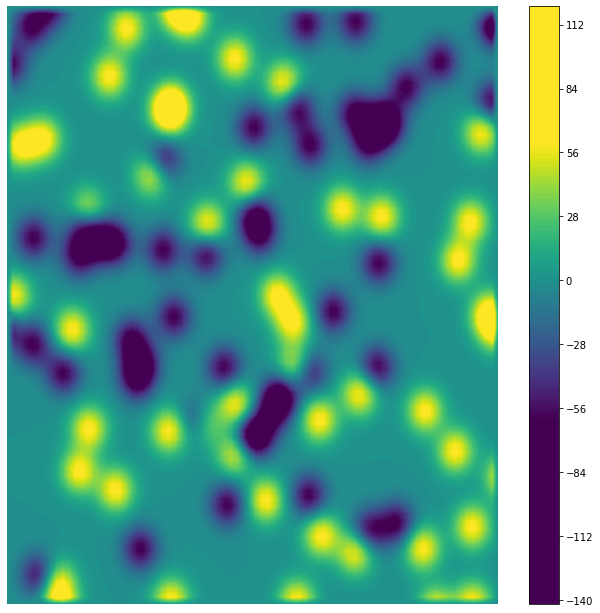

In [11]:
subplots(figsize=(11, 11))
cp = contourf(X, Y, b_1, levels=160, vmin=-60, vmax=60)
colorbar(cp)
axis("off");

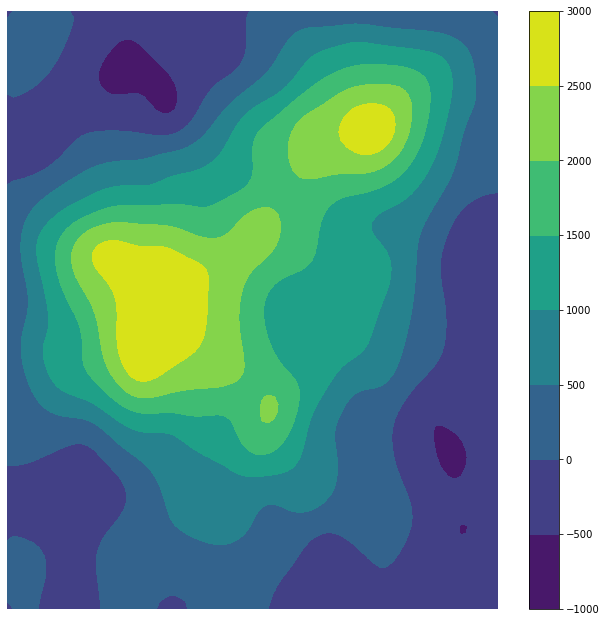

In [12]:
subplots(figsize=(11, 11))
cp = contourf(X, Y, phi)
colorbar(cp)
axis("off");

In [13]:
Out = GMRES_numba(A_numba, b_1, np.ones_like(phi), e, nmax_iter, restart, True)

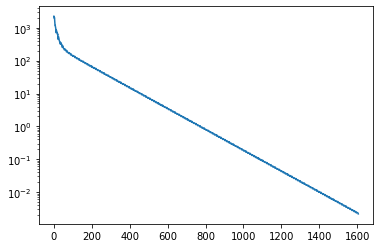

In [14]:
semilogy(resid(A_numba, Out, b_1))

In [15]:
from src_dir import Gauss_pdf_2D, resid, StatusPrinter

#Set the numpy seed
np.random.seed(0)

# Initialize lists that hold time data (time-to-solutuin, trainining time,
# MLGMRES time, etc)
run_time_ML_list     = []
GmresRunTimeOriginal = []
SpeedUp              = []
trainTime_list       = []

# Set debug mode (prints more information to screen)
debug = True

NonML_Err_List      = []
NonML_Err_List_Full = []

# Initial condition and initial time
t = dt

# Index of  Poisson problems solved
for ProbIdx in range(n_steps):

    # First GMRES call (solve up to e1 tolerance) with ML wrapper
    trainer.ProbCount = ProbIdx  # TODO: This should probably be automatically incremented
    p_1, v_1, b_1, phi, phi_x, phi_y, Out, run_time1_ML = time_step(
        MLGMRES, 1, dt, dx, X, Y, p_0, v_0, p_lo, p_hi, charge, 0.05
    )
    # Out, run_time1_ML = MLGMRES(A, b, x0, e, nmax_iter, restart, debug)

    # Collect ML assisted Run-times
    run_time_ML_list.append(run_time1_ML)
    if len(trainer.trainTime) > 0:
        trainTime_list.append(trainer.trainTime[-1]) # TODO: this second list is not needed
    
    # Direct GMRES call up to e1 tolerance
    _, _, _, _, _, _, NonML_Out1, run_time1 = time_step(
        GMRES_timed, 1, 0, dx, X, Y, p_0, v_0, p_lo, p_hi, charge, 0.05
    )
    # NonML_Out1, run_time1 = GMRES_timed(A, b, x0, e, nmax_iter, restart, debug)  
    NonML_Err = resid(A_numba, NonML_Out1, b_1)
    NonML_Err_List_Full.append(NonML_Err)
    NonML_Err_List.append(NonML_Err[3])
    ## Collect  direct GMRES timeHeatSource
    GmresRunTimeOriginal.append(run_time1)

    ## Ratio of run-timesHeatSource
    SpeedUp.append(run_time1/trainer.ML_GMRES_Time_list[-1])

    # Update user on status
    StatusPrinter().update_simulation(SpeedUp[-1], ProbIdx)

    # Next time step
    t   = t + dt
    p_0 = p_1
    v_0 = v_1

StatusPrinter().finalize()


MLGMRES_GMRES_ONLY = sum(trainer.ML_GMRES_Time_list)
run_time           = sum(GmresRunTimeOriginal)
run_time_ML        = sum(run_time_ML_list)
trainTime_total    = sum(trainTime_list)

print("Runtime of Non-decorated version is: ",     run_time)
print("Runtime of MLGMRES decorator is: ",         run_time_ML)
print("Runtime of MLGMRES (only GMRES time) is: ", MLGMRES_GMRES_ONLY)
print("Runtime of training (backprop) is: ",       trainTime_total)

/global/homes/b/blaschke/.conda/envs/conda_local/lib/python3.7/site-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


/global/homes/b/blaschke/.conda/envs/conda_local/lib/python3.7/site-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


iter=9999 speedup=1.5705 loss=2.0135e-02 parameters=13883 data size=388
Runtime of Non-decorated version is:  2970.520778979466
Runtime of MLGMRES decorator is:  4969.872757032164
Runtime of MLGMRES (only GMRES time) is:  2105.933778823819
Runtime of training (backprop) is:  63162.44846314599


In [16]:
from src_dir import moving_average

# Compute moving average of GMRES and MLGMRES error
AVG   = np.zeros((n_steps, 1))
count = np.arange(0, n_steps)

Err_Array = np.asarray(NonML_Err_List)
count     = np.arange(0, n_steps)
for j in range(0, n_steps):
    AVG[j] = moving_average(np.asarray(Err_Array[:j]), j)

Err_Array_ML = np.asarray(trainer.Err_list)
AVGML        = np.zeros((n_steps, 1))
for j in range(0, n_steps):
    AVGML[j] = moving_average(np.asarray(Err_Array_ML[:j]), j)    

# Compute moving average of GMRES and MLGMRES run-times
GmresRunTimeOriginal_AVG = np.zeros((n_steps, 1))
ML_GMRES_Time_AVG        = np.zeros((n_steps, 1))

for j in range(0, n_steps):
    GmresRunTimeOriginal_AVG[j] = moving_average(np.asarray(GmresRunTimeOriginal[:j]), j)

for j in range(0, n_steps):
    ML_GMRES_Time_AVG[j] = moving_average(np.asarray(trainer.ML_GMRES_Time_list[:j]), j)

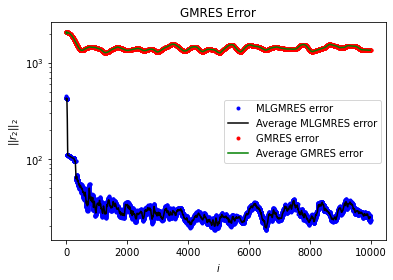

In [17]:
# plot(count,Err_Array_ML,'.b',label='MLGMRES error')
# plot(count[10:-1],AVGML[10:-1],'k',label='Average MLGMRES error')
# plot(count,Err_Array,'.r',label='GMRES error')
# plot(count[10:-1],AVG[10:-1],'g',label='Average GMRES error')

plot(Err_Array_ML,'.b',label='MLGMRES error')
plot(AVGML[10:-1],'k',label='Average MLGMRES error')
plot(Err_Array,'.r',label='GMRES error')
plot(AVG[10:-1],'g',label='Average GMRES error')

title('GMRES Error')
xlabel('$i$')
ylabel('$||r_2||_2$')
legend(loc='best')
yscale("log")
# pp.savefig('AdvectDiff_Error.png')

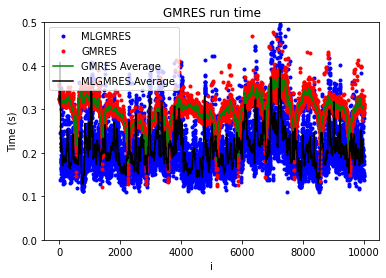

In [19]:
# plot(trainer.ML_GMRES_Time_list,'.b',label='MLGMRES')
# plot(GmresRunTimeOriginal,'.r', label='GMRES')
# plot(count[20:-1],GmresRunTimeOriginal_AVG[20:-1],'g', label='GMRES Average')
# plot(count[20:-1],ML_GMRES_Time_AVG[20:-1],'k', label='MLGMRES Average')

plot(trainer.ML_GMRES_Time_list,'.b',label='MLGMRES')
plot(GmresRunTimeOriginal,'.r', label='GMRES')
plot(GmresRunTimeOriginal_AVG[20:-1],'g', label='GMRES Average')
plot(ML_GMRES_Time_AVG[20:-1],'k', label='MLGMRES Average')

ylim(0, 0.5)

ylabel('Time (s)')
xlabel('i')
title('GMRES run time')
legend(loc='best')
# pp.savefig('AdvectDiff_time.png')

Text(0.5, 1.0, 'Convergence of Algorithim for Final Linear Problem')

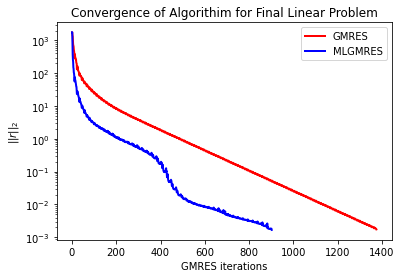

In [20]:
RHSIndex=-1
semilogy(NonML_Err_List_Full[RHSIndex],'r',label='GMRES',linewidth=2)
semilogy(trainer.IterErrList[RHSIndex],'b',label='MLGMRES',linewidth=2)
legend(loc='best')
xlabel('GMRES iterations')
ylabel('$||r||_2$')
title('Convergence of Algorithim for Final Linear Problem')

# savefig('AdvectDiff_EQ_Converg.png')

Text(0.5, 1.0, 'NN Speed Up ')

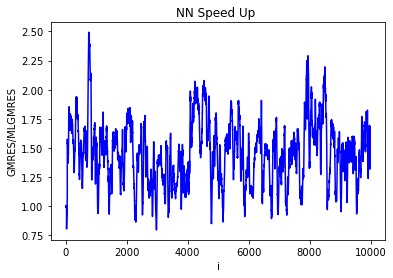

In [21]:
GMRESAVG=GmresRunTimeOriginal_AVG[10:-1]
MLGMRESAVG=ML_GMRES_Time_AVG[10:-1]
Ratio=np.divide(GMRESAVG,MLGMRESAVG)

plot(Ratio,'b')
xlabel('i')
ylabel('GMRES/MLGMRES')
title("NN Speed Up ")

# savetxt("SpeedupAdvectDiff.txt",Ratio)
# savefig('SpeedUp_AdvectDiff.png')